# Noise Model

In this notebook we take a closer look at the noise model and how it holds up under discretization.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from InverseProblemBayes import InverseProblemBayes

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian
from NavigationCircle import NavigationCircle as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test_2d = 100  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

meshDim = 50  # discretization parameter (1D) for FOM

dt = 0.01

## Setup

For the purposes of this notebook we go back to a simple flight in a circle. It's not actually important here, and can be switched out for any other flight path parameterization. 

In [3]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 4, 101))

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation)

Runtime of this block: 1.6389191150665283 s


## Inverse problems

We are primarily considering two types of inverse problems: the deterministic and the Bayesian. There are a lot of parallels between them, to the point that for the optimization we can treat them equivalently. The main difference lies in where the matrix over which we optimize (i.e. the information matrix / the posterior covariance matrix) comes from. 

In [4]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

# fly in a circle
alpha = np.array([0.25, 0.2])
flight = drone.plan_flight(alpha=alpha)

# measure data
data = drone.measure(flight=flight, state=state)

In [5]:
flight.grid_t

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
       1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
       1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16,
       2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 ,
       2.64, 2.68, 2.72, 2.76, 2.8 , 2.84, 2.88, 2.92, 2.96, 3.  , 3.04,
       3.08, 3.12, 3.16, 3.2 , 3.24, 3.28, 3.32, 3.36, 3.4 , 3.44, 3.48,
       3.52, 3.56, 3.6 , 3.64, 3.68, 3.72, 3.76, 3.8 , 3.84, 3.88, 3.92,
       3.96, 4.  ])

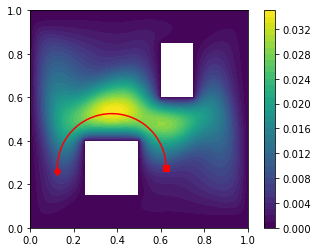

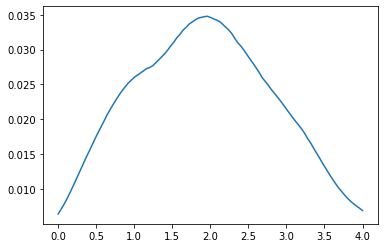

In [6]:
flightpath, grid_t = flight.flightpath, flight.grid_t

fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

fig, ax = plt.subplots(1,1)
ax.plot(grid_t, data)

### Deterministic
This is the model form that we've been using in the previous notebooks (without telling you). It's a bit easier to explain. Suppose we know the data $d$ lies in a Hilbert space $\mathcal{H} \subset L^2([0, T])$. Then, given observational data $d_{obs}$, we can pose the inverse problem as
$$
\min_{m} c_s \| d-d_{obs}\|_{\mathcal{H}}^2 + \|m-m_{pr}\|_{\Sigma_{pr}^{-1}}^2
\quad \text{such that $d$ is the measurement of the state $u(m)$}
$$
where $c_2 > 0$ is a scaling parameter. After discretization in time, the Hessian $\mathbf{H}$ of this problem, a.k.a. the \red{inverse?} Fisher information matrix, is
$$
\mathbf{H} = c_s \mathcal{F}^T \mathbf{I}_{\mathcal{H}} \mathcal{F} + \Sigma_{pr}^{-1}
$$
where $\mathbf{I}_{\mathcal{H}}$ is the inner product matrix for $\mathcal{H}$ and $\mathcal{F}$ the discretized parameter-to-observable map. If, abusing notation, we define
$$
\Sigma_{noise}^{-1} := c_s \mathbf{I}_{\mathcal{H}},
$$
then we arrive at the same matrix structure as in the Bayesian setting. The only "complication" we have is to choose the Hilbert space $\mathcal{H}$. The simplest choice that doesn't require any knowledge about the properties of the data beyond $d \in L^2([0,T])$ is to choose $\mathcal{H} = L^2([0,T])$ (duh!). In this case we have
$$
\Sigma_{noise}^{-1} := c_s \mathbf{M},
$$
where $\mathbf{M}$ is the mass matrix for the discretization of $\mathcal{H}$. Another obvious choice is $\mathcal{H} = H^1([0,T])$, in which case
$$
\Sigma_{noise}^{-1} := c_s c_d \mathbf{A} + c_s \mathbf{M},
$$
with stiffness matrix $\mathbf{A}$ and a diffusion scaling coefficient $c_d$. This choice penalizes large derivativess in the data, as caused by noise, and is therefore attractive. It can however be tricky in the time continuous limit to show that the data is indeed weakly differentiable.

In [7]:
inversion = InverseProblem(fom, drone)
inversion.set_noise_model(c_scaling = 1e+3, c_diffusion=0)
print("Norm of the data:", np.sqrt(inversion.compute_noisenorm2(data)))

Norm of the data: 1.5265492043268474


### Bayesian setting

In [38]:
inversionBayes = InverseProblemBayes(fom, drone)
inversionBayes.set_noise_model(c_scaling = 1e+3, c_diffusion = 0.1, c_boundary = (0.001)**2)
print("Norm of the data:", np.sqrt(inversionBayes.compute_noisenorm2(data)))

Norm of the data: 44.183084695920854


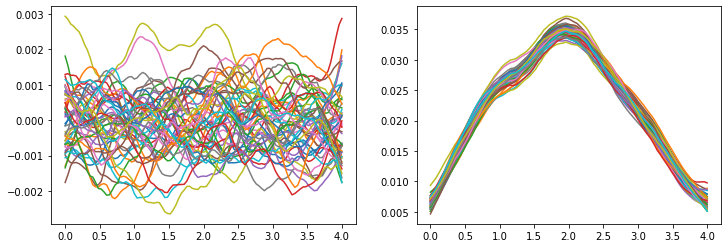

In [42]:
samples = inversionBayes.sample_noise(n_samples = 50)
fig, axs = plt.subplots(1,2, figsize = (12, 4))

for i in range(samples.shape[1]):
    axs[0].plot(grid_t, samples[:, i])
    axs[1].plot(grid_t, data + samples[:, i])